In [79]:
import numpy as np
import scipy.sparse.linalg as splin
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from pathlib import Path

## Basic parameters - not usually changed

In [80]:
a, b = 0, 1           # boundary points
alpha, beta = -1, 1.5 # boundary values
LABELSIZE = 15        # Base labelsize 
SUBFIG_LABELS = ["(a)", "(b)", "(c)", "(d)"]

In [82]:

# make directory if not already present
assignment_dir = Path.cwd() # directory for this working directory (if using notebook, it will be the direcotry of notebook)
figures_dir = assignment_dir / "figures" # figures directory
figures_dir.mkdir(parents=True, exist_ok=True) # create folder and parent directories, if not already existing.

## helper functions

In [83]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)
    format_dict = {
        'float_kind': lambda x: f"{x:>10.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", 110)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

## b) Solve equation using Newton's method

$$\begin{align*}
    \epsilon u'' + u(u' -1) = 0, &\quad 0\leq t \leq 1, \\
    u(0) = \alpha, &\quad u(1) = \beta, \\
    \alpha = -1, \quad \beta = 1.5, &\quad \epsilon = 0.1
\end{align*}$$

We are told that we may use 
$$
    u(x) \approx x - \bar x + w_0\tanh{\left(\frac{w_0(x-\bar x)}{2\epsilon}\right)}
$$
for our initial guess.

First we note that, rewriting as we have described in our assignemnt task 2a. a), we have that 
$$\begin{align*}
    \epsilon u'' + u(u' -1) &= 0 \\
    \Rightarrow \epsilon \frac{U_{j-1} - 2U_j + U_{j+1}}{h^2} + U_j\left(\frac{U_{j+1} - U_{j-1}}{2h} - 1\right) &= 0 \\
    \Rightarrow F_j(U) &= 0
\end{align*}$$

Then, we define the jacobian as
$$ 
    J_{ij}(U) = \frac{\partial}{\partial U_j} F_i(U)
$$

we then have the non-zero derivatives
$$\begin{align*}
    \frac{\partial}{\partial U_{i-1}}F_i(U) &= \epsilon\frac{1}{h^2} - \frac{U_i}{2h} \\
    \frac{\partial}{\partial U_{i}}F_i(U) &= -2\epsilon \frac{1}{h^2} + \frac{U_{i+1} - U_{i-1}}{2h} - 1\\
    \frac{\partial}{\partial U_{i+1}}F_i(U) &= \epsilon\frac{1}{h^2} + \frac{U_i}{2h}
\end{align*}$$

assuming we have a $N=7$, the matrix should be $7\times 7$ matrix, such that, $i, j \in \{0, 6\}$

We should get the Jacobian:
$$\begin{align*}
    J &= \begin{pmatrix}
        1       &           &           &        &          &           &       \\
        J_{10}  & J_{11}    & J_{12}    &        &          &           &       \\
                & J_{21}    & J_{22}    & J_{23} &          &           &       \\
                &           & J_{32}    & J_{33} & J_{34}   &           &       \\
                &           &           & J_{43} & J_{44}   & J_{45}    &       \\
                &           &           &        & J_{54}   & J_{55}    & J_{56}\\
                &           &           &        &          &           & 1     \\
    \end{pmatrix}
\end{align*}$$
with 
$$\begin{align*}
    F = \begin{pmatrix} \alpha \\ F_1 \\ F_2 \\ \vdots \\ F_{N-1} \\ \beta\end{pmatrix}
\end{align*}$$

If we want to reduce this matrix further we can use the $(N-2) \times (N-2)$ matrix
$$\begin{align*}
    \tilde{J} &= \begin{pmatrix}
        J_{11}  & J_{12}    &        &          &           \\
        J_{21}  & J_{22}    & J_{23} &          &           \\
                & J_{32}    & J_{33} & J_{34}   &           \\
                &           & J_{43} & J_{44}   & J_{45}    \\
                &           &        & J_{54}   & J_{55}    \\
    \end{pmatrix}
\end{align*}$$
with 
$$\begin{align*}
    \tilde{F} = \begin{pmatrix} F_1 - \dfrac{\alpha}{h^2} \\ F_2 \\ F_3 \\ \vdots \\ F_{N-1} - \dfrac{\beta}{h^2} \end{pmatrix}
\end{align*}$$

This results in the matrix for $ U = \begin{bmatrix} U_0 & U_1 & \cdots & U_5 \end{bmatrix}^T$
$$\begin{align*}
    \tilde{J} &= 
    \begin{pmatrix}
        \eta + \dfrac{U_2 - U_0}{2h}    & \tau + \dfrac{U_1}{2h} & 0 & 0 \\ \\
        \tau - \dfrac{U_2}{2h}        & \eta + \dfrac{U_3 - U_1}{2h}  & \tau + \dfrac{U_2}{2h} & 0 \\ \\
        0 & \tau - \dfrac{U_3}{2h}        & \eta + \dfrac{U_4 - U_2}{2h}  & \tau + \dfrac{U_3}{2h} \\ \\
        0 & 0 & \tau - \dfrac{U_4}{2h}        & \eta + \dfrac{U_5 - U_3}{2h}  \\ \\

    \end{pmatrix}, \quad \tau = \frac{\epsilon}{h^2}, \quad \eta = -2\tau - 1
\end{align*}$$


Summarizing, we have in the upper diagonal $J_{i,i+1} = \tau + \frac{U_i}{2h}$, and in the lower diagonal we have $J_{i,i-1} = \tau - \frac{U_{i-1}}{2h}$

Now, for the residuals, $\tilde{F}$, for $i = 1,2,\cdots, N-1$
$$\begin{align*}
    F_i(U)      &= \epsilon\dfrac{U_{i-1} - 2U_{i} + U_{i+1}}{h^2} + U_{i}\left(\dfrac{U_{i+1}-U_{i-1}}{2h} - 1\right) \\
    \\
    F_1(U)      &= \epsilon\dfrac{U_{0} - 2U_{1} + U_{2}}{h^2} + U_{1}\left(\dfrac{U_{2}-U_{0}}{2h} - 1\right) \\
                &= \epsilon\dfrac{\alpha - 2U_{1} + U_{2}}{h^2} + U_{1}\left(\dfrac{U_{2}-\alpha}{2h} - 1\right) \\
    \\
    F_{N-1}(U)  &= \epsilon\dfrac{U_{N-2} - 2U_{N-1} + U_{N}}{h^2} + U_{N-1}\left(\dfrac{U_{N}-U_{N-2}}{2h} - 1\right) \\
                &= \epsilon\dfrac{U_{i-1} - 2U_{i} + \beta}{h^2} + U_{i}\left(\dfrac{\beta-U_{i-1}}{2h} - 1\right) \\
\end{align*}$$

In [64]:
def initial_guess(N, eps, bound, BC, u_init = None):
    """Construct initial guess from eq. 2.105 in book, or using a linear start guess.
    In both cases the boundary terms is set explicitly
    """
    a, b = bound
    alpha, beta = BC
    ts = np.linspace(a, b, num=N, endpoint=True)
    
    tbar = 0.5 * (a + b - alpha - beta)
    w0 = 0.5 * (a - b + beta - alpha)
    
    if u_init is None or u_init.lower() == "book":
        u_init = ts - tbar + w0 * np.tanh(w0*(ts- tbar) / (2*eps))
    elif u_init == "linear":
        u_init = np.linspace(alpha, beta, num=N, endpoint=True)
    
    # Set boundary values
    u_init[0] = alpha
    u_init[-1] = beta
    return u_init, ts

def residual(U, epsilon):
    """Compute stencil"""
    
    N = len(U)
    
    h = 1/(N-1)
    upp = (U[2:] - 2*U[1:-1] + U[:-2]) / h**2
    up  = (U[2:] - U[:-2]) / (2*h)
    F = epsilon*upp + U[1:-1]*(up - 1) # Only computes the interior points.

    return sparse.csc_matrix(F).T

def Jacobian(U, epsilon):
    """Compute Jacobian for stencil"""
    N = len(U) # Full array (including boundary)
    h = 1/(N-1) 
    
    upper_diag =    epsilon/(h**2) + U[1:-2]/(2*h)
    main_diag  = -2*epsilon/(h**2) + (U[2:] - U[:-2])/(2*h) - 1    
    lower_diag =    epsilon/(h**2) - U[2:-1]/(2*h)
            
    J = sparse.diags([upper_diag, main_diag, lower_diag], offsets=[1, 0, -1], shape=(N-2,N-2), format="csc")
    return J

def Newton_iteration(U, eps):
    """Single iteration of Newtons method"""
    F = residual(U, eps)
    J = Jacobian(U, eps)
    
    DeltaU = splin.spsolve(J, -F)
    assert DeltaU.shape == U[1:-1].shape, f"Shape mismatch {DeltaU.shape} vs {U[1:-1].shape}"
    
    U[1:-1] += DeltaU # only update the interior points - ensures that boundary conditions hold
    return J, U, F

def Newtons_method(U, BC, eps, max_iter, tol):
    """Run Newtons method until it converges"""
    F0 = residual(U, eps)
    U_iter = U.copy()
    for iter in range(max_iter):
        ## Some advanced print-statement for counting loops.
        print(f"Running loop   : {iter+1:>{len(str(max_iter))+3},}/{max_iter:,}", end="\r")
        
        # Run an iteration of Newtons method
        J_iter, U_iter, F_iter = Newton_iteration(U_iter, eps)
        
        # Check for convergence of Newtons method
        rel_error = linalg.norm(F_iter.toarray(), np.inf) / (linalg.norm(F0.toarray(), np.inf))
        if (rel_error < tol):
            print() # avoid overwriting the Loop counter
            print(f"## Converged   : {rel_error:.4g} < tolerance")
            break # break for-loop
        elif iter+1 == max_iter:
            raise ValueError(f"Convergence error!\n         error: {rel_error:4g}\nprevious error: {rel_error_old:4g}")
        rel_error_old = rel_error
    print()
    return J_iter, U_iter, F_iter

In [65]:
u0, ts = initial_guess(17, 0.1, (a,b), (alpha, beta))
J, U, F = Newton_iteration(u0, 0.1)

In [ ]:
def get_solutions(grid_list, eps_list, bound, BC, max_iter, tol):
    """Run Newtons method with values of N and epsilon from `grid_list` and `eps_list`"""
    solutions = []
    for (N, epsilon) in zip(grid_list, eps_list):
        print(f"(epsilon, N) = ({epsilon:>3}, {N:>3})")
        
        u0, ts = initial_guess(N, epsilon, bound, BC)
        J_h, u_h, F_h = Newtons_method(u0, BC, epsilon, max_iter, tol)
        solutions.append([N, ts, J_h, u_h, F_h])
        
    return solutions


def norm_solutions(solutions):
    """Compute infinity-norm of solutions"""
    norm_solutions = []
    N_ref, t_ref, J_ref, U_ref, F_ref = solutions[-1]
    for N, t_h, J_h, U_h, F_h in solutions[:-1]:
        
        A_inv = splin.inv(J_h)
        norm_A_inv = splin.norm(A_inv, np.inf)
        
        U_interp = np.interp(t_h, t_ref, U_ref)
        norm_err = linalg.norm(U_h - U_interp, np.inf)
        
        norm_solutions.append([N, norm_A_inv, norm_err])
    
    return np.array(norm_solutions).squeeze()
        
grid_list = [2**i * 20 for i in range(4)]
eps_list  = [0.1,]*len(grid_list)
solutions = get_solutions(grid_list=grid_list, eps_list=eps_list, 
                                 bound=(a,b), BC=(alpha, beta), 
                                 max_iter=1_000, tol=1e-10)

_ = norm_solutions(solutions)
# norms

(epsilon, N) = (0.1,  20)
Running loop   :       5/1,000
## Converged   : 9.069e-16 < tolerance

(epsilon, N) = (0.1,  40)
Running loop   :       5/1,000
## Converged   : 1.88e-15 < tolerance

(epsilon, N) = (0.1,  80)
Running loop   :       5/1,000
## Converged   : 1.533e-15 < tolerance

(epsilon, N) = (0.1, 160)
Running loop   :       5/1,000
## Converged   : 1.638e-15 < tolerance



In [67]:
def plot_params(ax, subfig_label, title, labelsize):
    ax.set_title(title, size=labelsize+2)
    ax.legend(loc="lower right")
    ax.tick_params(axis='both', labelsize=labelsize-2)  # Set fontsize for both x and y ticks
    ax.text(0, 1, subfig_label, size=labelsize)
    ax.grid(alpha=0.8)

epsilon = 1
Running loop   :       4/1,000
## Converged   : 7.414e-15 < tolerance

epsilon = 0.1
Running loop   :       5/1,000
## Converged   : 1.952e-15 < tolerance

epsilon = 0.01
Running loop   :       4/1,000
## Converged   : 2.62e-12 < tolerance

epsilon = 0.001
Running loop   :       5/1,000
## Converged   : 6.231e-15 < tolerance



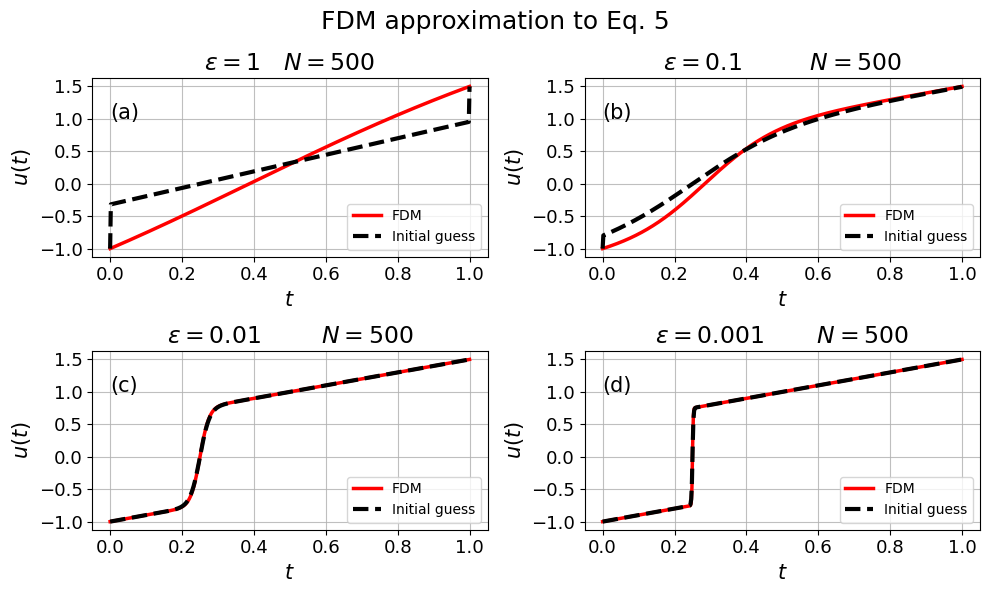

In [87]:
eps_list = [1, 0.1, 0.01, 0.001]
grid_list = [500,]*len(eps_list)

# grid_list = [2**i*20 for i in range(4)]
# eps_list  = [0.1,]*len(grid_list)
# solutions = get_solutions(grid_list=grid_list, eps_list=eps_list, 
#                                  bound=(a,b), BC=(alpha, beta), 
#                                  max_iter=5_000, tol=1e-11)

fig, ax = plt.subplots(2,2, figsize=(10,6), sharex=False, sharey=False)
ax = ax.flatten()

for iter, (N, epsilon) in enumerate(zip(grid_list, eps_list)):
    print(f"{epsilon = }")
    u0, ts = initial_guess(N, epsilon, bound=(a,b), BC=(alpha, beta), u_init="book")
    J, U, F = Newtons_method(u0, (alpha, beta), epsilon, max_iter=1_000, tol=1e-10)
    ax[iter].plot(ts, U, "r-", label="FDM", lw=2.5)
    # ax[iter].scatter(ts[N//2], U[N//2], label="Point chosen", lw=10) # investigate point on graph
    ax[iter].plot(ts, u0, "k--", label="Initial guess", lw=3)
    ax[iter].set_yticks([-1, -0.5, 0, 0.5, 1, 1.5])
    
    ax[iter].set_ylabel("$u(t)$", size=LABELSIZE)
    ax[iter].set_xlabel("$t$", size=LABELSIZE)
    plot_params(ax[iter], subfig_label=SUBFIG_LABELS[iter], 
                title=f"$\\epsilon = {epsilon}$\t $N = {N}$", labelsize=LABELSIZE)
    
fig.suptitle("FDM approximation to Eq. 5", fontsize=LABELSIZE+3)
fig.tight_layout()
    
file_name = "ex_2b.FMD.png"
fig.savefig(figures_dir / file_name, transparent=False)

In [91]:
grid_list = [2**i*50 for i in range(8)]
eps_list  = [0.1,]*len(grid_list)
solutions = get_solutions(grid_list, eps_list, 
                          bound=(a,b), BC=(alpha, beta), 
                          max_iter=1_000, tol=1e-10)

norms = norm_solutions(solutions)

(epsilon, N) = (0.1,  50)
Running loop   :       5/1,000
## Converged   : 2.092e-15 < tolerance

(epsilon, N) = (0.1, 100)
Running loop   :       5/1,000
## Converged   : 1.749e-15 < tolerance

(epsilon, N) = (0.1, 200)
Running loop   :       5/1,000
## Converged   : 1.928e-15 < tolerance

(epsilon, N) = (0.1, 400)
Running loop   :       5/1,000
## Converged   : 1.887e-15 < tolerance

(epsilon, N) = (0.1, 800)
Running loop   :       5/1,000
## Converged   : 1.811e-15 < tolerance

(epsilon, N) = (0.1, 1600)
Running loop   :       4/1,000
## Converged   : 7.27e-11 < tolerance

(epsilon, N) = (0.1, 3200)
Running loop   :       4/1,000
## Converged   : 1.833e-11 < tolerance

(epsilon, N) = (0.1, 6400)
Running loop   :       4/1,000
## Converged   : 4.603e-12 < tolerance



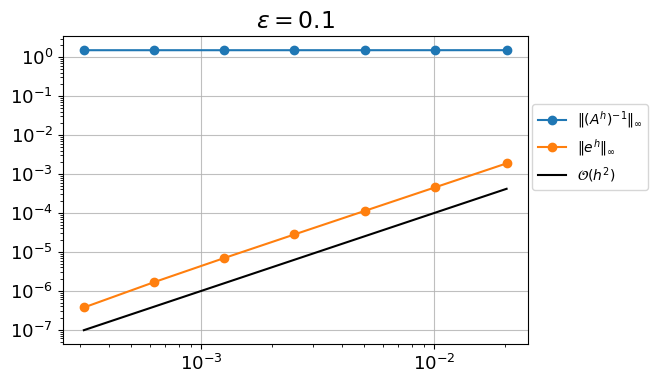

In [92]:
Ns = norms[:, 0]
hs = 1/(Ns - 1)
fig, ax = plt.subplots( figsize=(6,4))
ax.loglog(hs, norms[:, 1], "o-", label=r"$\|\left(A^h\right)^{-1}\|_\infty$")
ax.loglog(hs, norms[:, 2], "o-", label=r"$\| e^h\|_\infty$")
ax.loglog(hs, hs**2, "k-", label=r"$\mathcal{O}(h^2)$")
plot_params(ax, "", fr"$\epsilon = {eps_list[0]}$", LABELSIZE)
ax.legend(loc=(1.01, 0.5))

file_name = f"ex_2a.b_GEE_eps_{epsilon}.png"
fig.savefig(figures_dir / file_name, transparent=False)